In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf

%precision 3
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# 分散分析

平均値の差を検定する方法

## 分散分析が必要になるタイミング

- 3つ以上の水準間の平均値に差があるかを検定したい場合
  - t検定をしたときは、「薬を飲む前と飲んだ後」といった2つの水準間における平均値の差を検定することになる
  - 今回扱う問題は、「晴れor曇りor雨と天気が変わることにより売上が変化するといえるか」といった3つ以上の水準間の平均値の差を検定することになる

分散分析は、母集団が正規分布に従うデータに対して適用可能


## 検定の多重性

検定を繰り返すことによって有意な結果が得られやすくなる問題を **検定の多重性** と呼ぶ

- 有意水準を`0.05`と定めて検定を行ったとすると、第一種の過誤を犯す確率は5%
    - 例
        - 検定を2回続けて行うとし、各々の検定における有意水準は`0.05`とする
        - この時「少なくともどちらか片方の検定に置いて帰無仮説を棄却できれば対立仮説を採用する」というルールで検定を行うと、第一種の過誤を犯す確率は`1 - (0.95 * 0.95) = 0.0975`(=10%)となる

つまり、検定を繰り返すことにより、帰無仮説が棄却されやすくなり、第一種の過誤を犯す確率が増える

一方、分散分析だと、晴れ/曇り/雨などといった個別のカテゴリを見るのではなく「天気によってビールの売上が異なるかどうか」を一度の検定を判断することができるようになる

## 分散分析の直感的な考え方: F比

分散分析の帰無仮説と対立仮説は以下の通り

- 帰無仮説: 水準間で平均値に差はない
- 対立仮説: 水準間で平均値に差がある

$$ F比 = \frac{効果の分散の大きさ}{誤差の分散の大きさ} $$

- 分散分析では、データの変動を誤差と効果に分離し、F比を計算する
    - F比が大きいほど、誤差の大きさに比べて効果の影響が大きいということになる
    - 母集団分布が等分散正規分布である場合、F比は自由度を持つF分布に従う
        - 例えば、自由度が`n-1`のF分布に従うとき、`F(n-1, n-1)`と表記する
        - p値を計算し、p値が有意水準より小さい場合は帰無仮説を棄却する(t検定と同じ)

Note: 分散分析は、Analysis Of Varianceの略称でANOVAと呼ぶ


## 分散分析の直感的な考え方: 誤差と効果の分離

- 分散分析では、データの変動を誤差と効果に分離する
    - 誤差: どの水準に属しているかに関係なく、データの変動に影響を与える要因
    - 効果: どの水準に属しているかによってデータの変動に影響を与える要因


郡間変動: バイオリン同士の距離、つまり効果の大きさのことを郡間変動
郡内変動: 各々のバイオリンの幅、つまり誤差の大きさのことを郡内変動


In [18]:
# sample data
weather = ['cloudy', 'cloudy', 'rainy', 'rainy', 'sunny', 'sunny']
beer = [6,8,2,4,10,12]
weather_beer = pd.DataFrame({'weather': weather, 'beer': beer})

print(weather_beer)

  weather  beer
0  cloudy     6
1  cloudy     8
2   rainy     2
3   rainy     4
4   sunny    10
5   sunny    12


<AxesSubplot:xlabel='weather', ylabel='beer'>

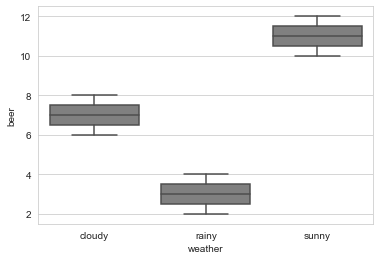

In [19]:
sns.boxplot(x='weather', y='beer', data=weather_beer, color='gray')

In [20]:
weather_beer.groupby("weather").mean()

,beer
weather,
cloudy,7.0
rainy,3.0
sunny,11.0


## 分散分析1 郡間・郡内平方話の計算



In [22]:
# 天気の持つ影響
effect = [7, 7, 3, 3, 11, 11]

# 群間の平方和
mu_effect = np.mean(effect)
squares_model = np.sum((effect - mu_effect) ** 2)
print('群間の平方和:', squares_model)

# 郡内の平方和:
resid = weather_beer.beer - effect
squares_resid = np.sum(resid ** 2)
print('郡内の平方和:', squares_resid)

群間の平方和: 64.0
郡内の平方和: 6


## 分散分析2 郡間・郡内分散の計算

In [23]:
df_model = 2 # 郡間変動の自由度 水準の種類(晴れ, 雨, 曇り) -1
df_resid = 3 # 郡内変動の自由度 サンプルサイズ(6) - 水準の種類(3)=3

# 郡間の平均平方(=分散)
variance_model = squares_model / df_model
print('郡間の平均平方:', variance_model)

# 郡内の平方平均(=分散)
variance_resid = squares_resid / df_resid
print('郡内の平均平方:', variance_resid)

郡間の平均平方: 32.0
郡内の平均平方: 2.0


## 分散分析3: p値の計算

In [24]:
f_ratio = variance_model / variance_resid
f_ratio

16.000

In [25]:
# p値の計算: F分布の累積分布関数から計算可能
1 - stats.f.cdf(f_ratio, df_model, df_resid)

0.025

p値が0.05以下となったので、天気によって売上は有意に変化すると判断できる

- 一元配置分散分析の計算について
    - データを「効果の大きさ」と「誤差の大きさ」に分離する
    - 各々の大きさを分散として定量化する(前者を郡間変動、後者を郡内変動)
    - 郡間の分散と郡内の分散の比(F比)を統計量として用いる
    - F分布の累積分布関数からp値を計算し、そのp値が0.05以下か否かを判定

## 説明変数がカテゴリ形である正規線形モデル

$$
\mathrm{ビールの売上~N(\beta_0 + \beta_1 (雨) + \beta_2(晴), \sigma^2)}
$$

- ここで「雨」は、天気が雨だった時に1を、それ以外の日には0をとる変数とする
- \beta_1, \beta_2は天気が雨/晴れの場合の影響を示すパラメタ
- 曇りのケースでは、雨でもなく晴れでもない場合は、\beta_0が残るので、これが曇りの係数と解釈される



### ダミー変数

- カテゴリ型の変数をモデルに組み込む際に用いられるのがダミー変数
- 雨: 0, 晴: 1, 曇: 2というように、カテゴリを数値に変換する
- カテゴリ型の変数をそのままモデルに組み込むことは難しいためダミー変数を利用する


In [26]:
# statsmodelsによる分散分析
anova_model = smf.ols('beer ~ weather', data=weather_beer).fit()
print(sm.stats.anova_lm(anova_model, typ=2))

          sum_sq   df     F    PR(>F)
weather     64.0  2.0  16.0  0.025095
Residual     6.0  3.0   NaN       NaN


In [27]:
anova_model.params
# intercept=\beta_0 つまり、曇りの日の売上の平均は、7になる

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

## モデルを用いて、誤差と効果を分離

In [28]:
fitted = anova_model.fittedvalues
# 効果
fitted

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

In [29]:
# 残差
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

In [32]:
beer = pd.read_csv('../data/5-1-1-beer.csv')

lm_model = smf.ols(formula='beer ~ temperature',
                   data = beer).fit()
sm.stats.anova_lm(lm_model, typ=2)

,sum_sq,df,F,PR(>F)
temperature,1651.532489,1.0,28.446984,0.000011
Residual,1625.582178,28.0,NaN,NaN


In [33]:
df_lm_model = 1
df_lm_reside = 28

# 当てはめ値
lm_effect = lm_model.fittedvalues
# 残差
lm_resid = lm_model.resid

mu = np.mean(lm_effect)
# 気温における効果の分散の大きさ
squares_lm_model = np.sum((lm_effect - mu) ** 2)
variance_lm_model = squares_lm_model / df_lm_model
# 残差の分散の大きさ
squares_lm_resid = np.sum(lm_resid ** 2)
variance_lm_resid = squares_lm_resid / df_lm_reside

# F比
f_value_lm = variance_lm_model / variance_lm_resid
f_value_lm

28.447

説明変数が1つだけの場合、係数のt検定の結果と分散分析の結果は一致する

In [34]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sat, 11 Feb 2023   Prob (F-statistic):           1.11e-05
Time:                        18:39:12   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""